# Average Reward Softmax Actor-Critic

**In this notebook, we will:**
    1. Implement softmax actor-critic agent on a continuing task using the average reward formulation.
    2. Understand how to parameterize the policy as a function to learn, in a discrete action environment.
    3. Understand how to (approximately) sample the gradient of this objective to update the actor.
    4. Understand how to update the critic using differential TD error.

## Pendulum Swing-Up Environment

Adapted from [Santamaría et al. (1998)](http://www.incompleteideas.net/papers/SSR-98.pdf). This is also the same environment that we used in the lecture. The diagram below illustrates the environment.

<img src="images/pendulum_env.png" alt="Drawing" style="width: 400px;"/>

The environment consists of single pendulum that can swing 360 degrees. The pendulum is actuated by applying a torque on its pivot point. The goal is to get the pendulum to balance up-right from its resting position (hanging down at the bottom with no velocity) and maintain it as long as possible. The pendulum can move freely, subject only to gravity and the action applied by the agent. 

The state is 2-dimensional, which consists of the current angle $\beta \in [-\pi, \pi]$ (angle from the vertical upright position) and current angular velocity $\dot{\beta} \in (-2\pi, 2\pi)$. The angular velocity is constrained in order to avoid damaging the pendulum system. If the angular velocity reaches this limit during simulation, the pendulum is reset to the resting position. 
The action is the angular acceleration, with discrete values $a \in \{-1, 0, 1\}$ applied to the pendulum.
For more details on environment dynamics you can refer to the original paper.

The goal is to swing-up the pendulum and maintain its upright angle. Hence, the reward is the negative absolute angle from the vertical position: $R_{t} = -|\beta_{t}|$

Furthermore, since the goal is to reach and maintain a vertical position, there are no terminations nor episodes. Thus this problem can be formulated as a continuing task.

Similar to the Mountain Car task, the action in this pendulum environment is not strong enough to move the pendulum directly to the desired position. The agent must learn to first move the pendulum away from its desired position and gain enough momentum to successfully swing-up the pendulum. And even after reaching the upright position the agent must learn to continually balance the pendulum in this unstable position.

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import itertools
from tqdm import tqdm

from source.rl_glue import RLGlue
from source.pendulum_env import PendulumEnvironment
from source.agent import BaseAgent
import source.plot_script as ps
import source.tiles3 as tc

Tile-coding is introduced in Section 9.5.4 of the [textbook](http://incompleteideas.net/book/RLbook2020.pdf) as a way to create features that can both provide good generalization and discrimination.

We will also use the [Tiles3 library](http://incompleteideas.net/tiles/tiles3.html).

To get the tile coder working we need to:

    1) create an index hash table using tc.IHT(), 
    2) scale the inputs for the tile coder based on number of tiles and range of values each input could take
    3) call tc.tileswrap to get active tiles back.

However, we need to make one small change to this tile coder.
Note that in this environment the state space contains angle, which is between $[-\pi, \pi]$. If we tile-code this state space in the usual way, the agent may think the value of states corresponding to an angle of $-\pi$ is very different from angle of $\pi$ when in fact they are the same! To remedy this and allow generalization between angle $= -\pi$ and angle $= \pi$, we need to use **wrap tile coder**.

The usage of wrap tile coder is almost identical to the original tile coder, except that we also need to provide the `wrapwidth` argument for the dimension we want to wrap over (hence only for angle, and `None` for angular velocity).

In [2]:
class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same
                            
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles 
        self.iht = tc.IHT(iht_size)
    
    def get_tiles(self, angle, ang_vel):
        """
        Takes in an angle and angular velocity from the pendulum environment
        and returns a numpy array of active tiles.
        
        Arguments:
        angle -- float, the angle of the pendulum between -np.pi and np.pi
        ang_vel -- float, the angular velocity of the agent between -2*np.pi and 2*np.pi
        
        returns:
        tiles -- np.array, active tiles
        
        """
        
        ### Use the ranges above and scale the angle and angular velocity between [0, 1]
        # then multiply by the number of tiles so they are scaled between [0, self.num_tiles]
        
        angle_scaled = 0
        ang_vel_scaled = 0
        
        MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
        MIN_VEL, MAX_VEL = -2*np.pi, 2*np.pi
        
        angle_scale = self.num_tiles / np.abs(MAX_ANGLE - MIN_ANGLE)
        ang_vel_scale = self.num_tiles / np.abs(MAX_VEL - MIN_VEL)
        
        angle_scaled = angle_scale * (MIN_ANGLE + angle)
        ang_vel_scaled = ang_vel_scale * (MIN_VEL + ang_vel)
        
        # Get tiles by calling tc.tileswrap method
        # wrapwidths specify which dimension to wrap over and its wrapwidth
        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle_scaled, ang_vel_scaled], wrapwidths=[self.num_tiles, False])
                    
        return np.array(tiles)

## Create Average Reward Softmax Actor-Critic Agent

Now that we implemented PendulumTileCoder let's create the agent that interacts with the environment.

This agent has two components: an Actor and a Critic. The Actor learns a parameterized policy while the Critic learns a state-value function. The environment has discrete actions; the Actor implementation will use a softmax policy with exponentiated action-preferences. The Actor learns with the sample-based estimate for the gradient of the average reward objective. The Critic learns using the average reward version of the semi-gradient TD(0) algorithm.

## Compute Softmax Probability

This function computes softmax probability for all actions, given actor weights `actor_w` and active tiles `tiles`. This function will be later used in `agent_policy` to sample appropriate action.

Recall how the softmax policy is represented from state-action preferences: $\large \pi(a|s, \mathbf{\theta}) \doteq \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}}$.

**state-action preference** is defined as $h(s,a, \mathbf{\theta}) \doteq \mathbf{\theta}^T \mathbf{x}_h(s,a)$.

Given active tiles `tiles` for state `s`, state-action preference $\mathbf{\theta}^T \mathbf{x}_h(s,a)$ can be computed by `actor_w[a][tiles].sum()`.

We will also use **exp-normalize trick**, in order to avoid possible numerical overflow. 
Consider the following:

$\large \pi(a|s, \mathbf{\theta}) \doteq \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}} = \frac{e^{h(s,a,\mathbf{\theta}) - c} e^c}{\sum_{b}e^{h(s,b,\mathbf{\theta}) - c} e^c} = \frac{e^{h(s,a,\mathbf{\theta}) - c}}{\sum_{b}e^{h(s,b,\mathbf{\theta}) - c}}$ 

$\pi(\cdot|s, \mathbf{\theta})$ is shift-invariant, and the policy remains the same when we subtract a constant $c \in \mathbb{R}$ from state-action preferences.

Normally we use $c = \max_b h(s,b, \mathbf{\theta})$, to prevent any overflow due to exponentiating large numbers.

In [3]:
def compute_softmax_prob(actor_w, tiles):
    """
    Computes softmax probability for all actions
    
    Args:
    actor_w - np.array, an array of actor weights
    tiles - np.array, an array of active tiles
    
    Returns:
    softmax_prob - np.array, an array of size equal to num. actions, and sums to 1.
    """
    
    # First compute the list of state-action preferences
    state_action_preferences = []
    actions = list(range(3))
    state_action_preferences = [actor_w[a][tiles].sum() for a in actions]
    
    # Set the constant c by finding the maximum of state-action preferences
    c = np.max(state_action_preferences)
    
    numerator = [np.exp(state_action_preference - c) for state_action_preference in state_action_preferences]
    denominator = np.sum(numerator)

    softmax_prob = [num / denominator for num in numerator]
    
    return softmax_prob

## Agent Methods

Now that we have implemented helper functions, let's create an agent. We do not need to implement `agent_end()` because there is no termination in our continuing task. 

We approximate $q_\pi$ in the Actor update using one-step bootstrapped return($R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w})$) subtracted by current state-value($\hat{v}(S_{t}, \mathbf{w})$), equivalent to TD error $\delta$.

$\delta_t = R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w}) - \hat{v}(S_{t}, \mathbf{w}) \hspace{6em}$

**Average Reward update rule**: $\bar{R} \leftarrow \bar{R} + \alpha^{\bar{R}}\delta \hspace{4.3em}$

**Critic weight update rule**: $\mathbf{w} \leftarrow \mathbf{w} + \alpha^{\mathbf{w}}\delta\nabla \hat{v}(s,\mathbf{w}) \hspace{2.5em}$

**Actor weight update rule**: $\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha^{\mathbf{\theta}}\delta\nabla ln \pi(A|S,\mathbf{\theta}) \hspace{1.4em}$


However, since we are using linear function approximation and parameterizing a softmax policy, the above update rule can be further simplified using:

$\nabla \hat{v}(s,\mathbf{w}) = \mathbf{x}(s) \hspace{14.2em}$

$\nabla ln \pi(A|S,\mathbf{\theta}) = \mathbf{x}_h(s,a) - \sum_b \pi(b|s, \mathbf{\theta})\mathbf{x}_h(s,b) \hspace{3.3em}$


In [4]:
class ActorCriticSoftmaxAgent(BaseAgent): 
    def __init__(self):
        self.rand_generator = None

        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.tc = None

        self.avg_reward = None
        self.critic_w = None
        self.actor_w = None

        self.actions = None

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None
    
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            "iht_size": int
            "num_tilings": int,
            "num_tiles": int,
            "actor_step_size": float,
            "critic_step_size": float,
            "avg_reward_step_size": float,
            "num_actions": int,
            "seed": int
        }
        """

        # set random seed for each run
        self.rand_generator = np.random.RandomState(agent_info.get("seed")) 

        iht_size = agent_info.get("iht_size")
        num_tilings = agent_info.get("num_tilings")
        num_tiles = agent_info.get("num_tiles")

        # initialize self.tc to the tile coder we created
        self.tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

        # set step-size accordingly (we normally divide actor and critic step-size by num. tilings (p.217-218 of textbook))
        self.actor_step_size = agent_info.get("actor_step_size")/num_tilings
        self.critic_step_size = agent_info.get("critic_step_size")/num_tilings
        self.avg_reward_step_size = agent_info.get("avg_reward_step_size")

        self.actions = list(range(agent_info.get("num_actions")))

        # Set initial values of average reward, actor weights, and critic weights
        # We initialize actor weights to three times the iht_size. 
        # Recall this is because we need to have one set of weights for each of the three actions.
        self.avg_reward = 0.0
        self.actor_w = np.zeros((len(self.actions), iht_size))
        self.critic_w = np.zeros(iht_size)

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None
    
    def agent_policy(self, active_tiles):
        """ policy of the agent
        Args:
            active_tiles (Numpy array): active tiles returned by tile coder
            
        Returns:
            The action selected according to the policy
        """
        
        # compute softmax probability
        softmax_prob = compute_softmax_prob(self.actor_w, active_tiles)
        
        # Sample action from the softmax probability array
        # self.rand_generator.choice() selects an element from the array with the specified probability
        chosen_action = self.rand_generator.choice(self.actions, p=softmax_prob)
        
        # save softmax_prob as it will be useful later when updating the Actor
        self.softmax_prob = softmax_prob
        
        return chosen_action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the environment's env_start function.
        Returns:
            The first action the agent takes.
        """

        angle, ang_vel = state
        active_tiles = self.tc.get_tiles(angle, ang_vel)
        current_action = self.agent_policy(active_tiles)

        self.last_action = current_action
        self.prev_tiles = np.copy(active_tiles)

        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the environment's step based on 
                                where the agent ended up after the
                                last step.
        Returns:
            The action the agent is taking.
        """

        angle, ang_vel = state
        active_tiles = self.tc.get_tiles(angle, ang_vel)

        v = self.critic_w[active_tiles].sum()
        v_prev = self.critic_w[self.prev_tiles].sum()
        delta = reward - self.avg_reward + v - v_prev

        self.avg_reward += self.avg_reward_step_size * delta
        
        self.critic_w[self.prev_tiles] += self.critic_step_size * delta #* 1 #active_tiles

        # update actor weights
        for a in self.actions:
            if a == self.last_action:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (1 - self.softmax_prob[a])
            else:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (0 - self.softmax_prob[a])

        current_action = self.agent_policy(active_tiles)

        self.prev_tiles = active_tiles
        self.last_action = current_action

        return self.last_action


    def agent_message(self, message):
        if message == 'get avg reward':
            return self.avg_reward


## Run Experiment

## Run Experiment

In [5]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)
            
    # sweep agent parameters
    for num_tilings in agent_parameters['num_tilings']:
        for num_tiles in agent_parameters["num_tiles"]:
            for actor_ss in agent_parameters["actor_step_size"]:
                for critic_ss in agent_parameters["critic_step_size"]:
                    for avg_reward_ss in agent_parameters["avg_reward_step_size"]:
                        
                        env_info = {}
                        agent_info = {"num_tilings": num_tilings,
                                      "num_tiles": num_tiles,
                                      "actor_step_size": actor_ss,
                                      "critic_step_size": critic_ss,
                                      "avg_reward_step_size": avg_reward_ss,
                                      "num_actions": agent_parameters["num_actions"],
                                      "iht_size": agent_parameters["iht_size"]}            
            
                        # results to save
                        return_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))
                        exp_avg_reward_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))

                        # using tqdm we visualize progress bars 
                        for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                            env_info["seed"] = run
                            agent_info["seed"] = run
                
                            rl_glue.rl_init(agent_info, env_info)
                            rl_glue.rl_start()

                            num_steps = 0
                            total_return = 0.
                            return_arr = []

                            # exponential average reward without initial bias
                            exp_avg_reward = 0.0
                            exp_avg_reward_ss = 0.01
                            exp_avg_reward_normalizer = 0

                            while num_steps < experiment_parameters['max_steps']:
                                num_steps += 1
                                
                                rl_step_result = rl_glue.rl_step()
                                
                                reward = rl_step_result[0]
                                total_return += reward
                                return_arr.append(reward)
                                avg_reward = rl_glue.rl_agent_message("get avg reward")

                                exp_avg_reward_normalizer = exp_avg_reward_normalizer + exp_avg_reward_ss * (1 - exp_avg_reward_normalizer)
                                ss = exp_avg_reward_ss / exp_avg_reward_normalizer
                                exp_avg_reward += ss * (reward - exp_avg_reward)
                                
                                return_per_step[run-1][num_steps-1] = total_return
                                exp_avg_reward_per_step[run-1][num_steps-1] = exp_avg_reward
                                                        
                        if not os.path.exists('results'):
                            os.makedirs('results')
                
                        save_name = "ActorCriticSoftmax_tilings_{}_tiledim_{}_actor_ss_{}_critic_ss_{}_avg_reward_ss_{}".format(num_tilings, num_tiles, actor_ss, critic_ss, avg_reward_ss)
                        total_return_filename = "results/{}_total_return.npy".format(save_name)
                        exp_avg_reward_filename = "results/{}_exp_avg_reward.npy".format(save_name)

                        np.save(total_return_filename, return_per_step)
                        np.save(exp_avg_reward_filename, exp_avg_reward_per_step)

## Run Experiment with 32 tilings, size 8x8

We will first test our implementation using 32 tilings, of size 8x8. We saw from the earlier assignment using tile-coding that many tilings promote fine discrimination, and broad tiles allows more generalization.
We conducted a wide sweep of meta-parameters in order to find the best meta-parameters for our Pendulum Swing-up task. 

We swept over the following range of meta-parameters and the best meta-parameter is boldfaced below:

actor step-size: $\{\frac{2^{-6}}{32}, \frac{2^{-5}}{32}, \frac{2^{-4}}{32}, \frac{2^{-3}}{32}, \mathbf{\frac{2^{-2}}{32}}, \frac{2^{-1}}{32}, \frac{2^{0}}{32}, \frac{2^{1}}{32}\}$

critic step-size: $\{\frac{2^{-4}}{32}, \frac{2^{-3}}{32}, \frac{2^{-2}}{32}, \frac{2^{-1}}{32}, \frac{2^{0}}{32}, \mathbf{\frac{2^{1}}{32}}, \frac{3}{32}, \frac{2^{2}}{32}\}$

avg reward step-size: $\{2^{-11}, 2^{-10} , 2^{-9} , 2^{-8}, 2^{-7}, \mathbf{2^{-6}}, 2^{-5}, 2^{-4}, 2^{-3}, 2^{-2}\}$  


We will do 50 runs using the above best meta-parameter setting to verify your agent.
Note that running the experiment cell below will take **_approximately 5 min_**.

In [6]:
experiment_parameters = {
    "max_steps" : 20000,
    "num_runs" : 50
}

# Environment parameters
environment_parameters = {}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
# actor and critic step-sizes are divided by num. tilings inside the agent
agent_parameters = {
    "num_tilings": [32],
    "num_tiles": [8],
    "actor_step_size": [2**(-2)],
    "critic_step_size": [2**1],
    "avg_reward_step_size": [2**(-6)],
    "num_actions": 3,
    "iht_size": 4096
}

current_env = PendulumEnvironment
current_agent = ActorCriticSoftmaxAgent


run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:15<00:00,  2.72s/it]


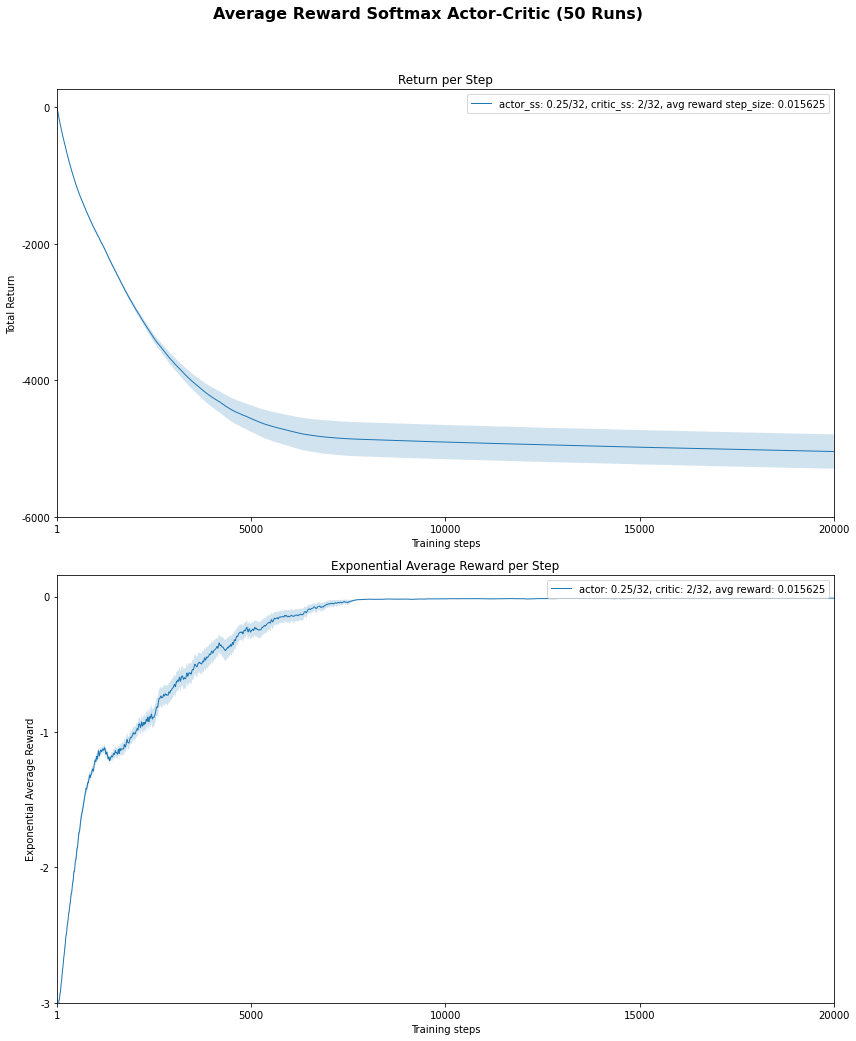

In [7]:
ps.plot_result(agent_parameters, 'results')